In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Reference articles: 

http://leonidzhukov.net/hse/2014/socialnetworks/papers/2000SiamRev.pdf<br>
https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf<br>
https://www.npr.org/sections/health-shots/2020/04/01/824744490/5-key-facts-the-white-house-isnt-saying-about-their-covid-19-projections <br>

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/<br>
https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296 <br>
https://towardsdatascience.com/building-your-own-covid-19-epidemic-simple-model-using-python-e39788fbda55 <br>
https://medium.com/@andrea.castiglioni/covid-19-corona-virus-analysis-in-italy-with-python-and-spread-prediction-d787d46bfc6f<br>

Demographic, age groups
https://gist.github.com/eeddaann/c4c8368218534c14ff1b366041b6c1a3<br>

In [55]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

# Baseline SEIR Model (no social distancing)

Text(0.5, 0, 'Time (Days)')

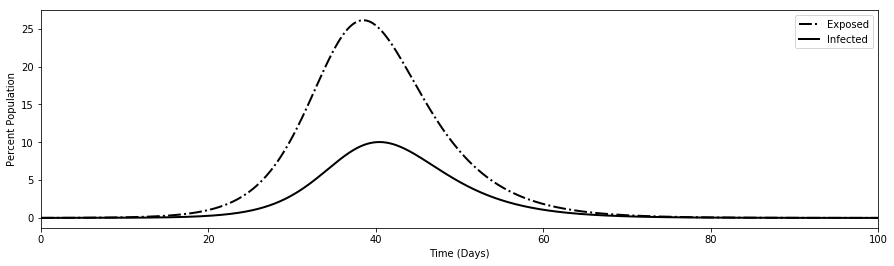

In [85]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma

# Run simulation
results = base_seir_model(init_vals, params, t)
df = pd.DataFrame(results, index = t, columns = ["Susceptible", "Exposed", "Infected", "Recovered"])
df = df.multiply(100)
ax = df[["Exposed", "Infected"]].plot(figsize=(15,4), lw = 2, style =['k-.', 'k-'])
# Set the axis labels
ax.set_ylabel("Percent Population")
ax.set_xlabel("Time (Days)")

## Parametric Model for Social Distancing
 We establish a social distancing factor or encounter rate (ρ) and sweep it from 0 to 1 where <br>
    * 0 means everyone is locked down,and <br>
    * 1 is the case of no social distancing as above
Below we consider a scenario of cutting the encounter rates by 50% (through social distancing policies)

1
0.5


Text(0.5, 0, 'Time (Days)')

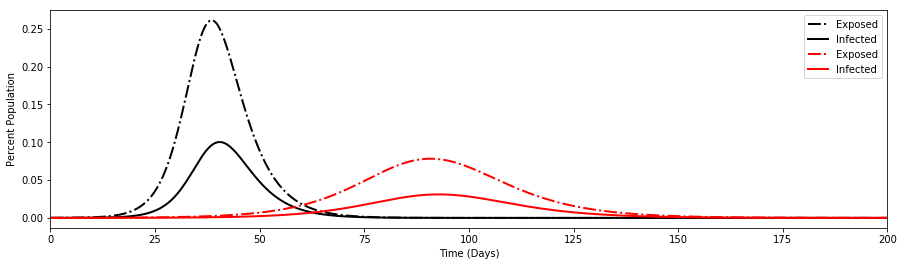

In [83]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma

# Run simulation
fig, ax = plt.subplots()
dg = pd.DataFrame()
rho = [1, 0.5]
colors = ['k', 'r']
for idx in range(0,len(rho)):
    print(rho[idx])
    df = pd.DataFrame()
    params = alpha, beta, gamma, rho[idx]
    results = seir_model_with_soc_dist(init_vals, params, t)
    df = pd.DataFrame(results, index = t, columns = ["Susceptible", "Exposed", "Infected", "Recovered"])
    df[["Exposed", "Infected"]].plot(figsize=(15,4), ax=ax, lw = 2, style = [colors[idx] + '-.', colors[idx] + '-'])
    df = df.multiply(100)
    dg = pd.concat([dg, df], axis = 1, sort = False)
#ax = df[["Exposed", "Infected"]].plot(figsize=(15,4))
# Set the axis labels
ax.set_ylabel("Percent Population")
ax.set_xlabel("Time (Days)")

# SIR Model

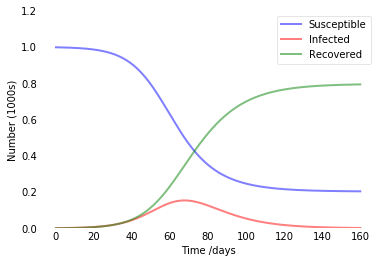

In [91]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()